# Netflix Content Engagement Prediction : End-to-End ML Pipeline

**Author:** Utkarsh Panchal  
**Platform:** Google Colab + AWS SageMaker  
**Goal:** Build a production-ready ML pipeline that predicts how users engage with Netflix content based on metadata and engineered behavioral features.

---

## Business Context

In modern streaming platforms, understanding **how likely users are to engage** with a show or movie is critical for:
- Personalized recommendations  
- Catalog optimization (which content to invest in or promote)  
- Ad-free vs. ad-tier decisions  
- Reducing user churn by recommending the right titles at the right time  

Netflix and similar platforms generate **massive amounts of data** - titles, genres, durations, ratings, and user behavior.  
The challenge is converting this data into actionable intelligence using ML.

---

## Problem Statement

We aim to build an ML system that can:
1. **Predict user rating (1–5 stars)** for each title → *Regression problem*  
2. **Predict whether a user will like a title (binary)** → *Classification problem*  

By doing so, we simulate a **recommendation readiness model**, which can later be integrated into a larger recommendation engine.

---

## Technical Overview

| Phase | Objective | Key Techniques |
|-------|------------|----------------|
| **Data Preparation** | Clean and transform raw Netflix dataset | Feature engineering, datetime parsing, encoding, imputation |
| **Model Development** | Train regression & classification models | XGBoost, hyperparameter tuning, cross-validation |
| **Deployment (Optional)** | Host models on AWS SageMaker | Endpoint creation, real-time inference |
| **Monitoring** | Track endpoint latency & errors | AWS CloudWatch integration |
| **Visualization** | Analyze top genres, predicted vs. actual ratings | Seaborn, Matplotlib dashboards |

---

## Business Value

- Enables Netflix to **predict viewer satisfaction** before content release  
- Supports **data-driven acquisition** by identifying content categories with high potential engagement  
- Provides a foundation for **personalized recommendation systems**  
- Demonstrates scalable **MLOps practices** using AWS infrastructure  

---

## Pipeline Diagram

```text
[Raw Data]
   ↓
[Data Cleaning & Feature Engineering]
   ↓
[Train-Test Split]
   ↓
[Model Training (Regression + Classification)]
   ↓
[Evaluation & Metrics]
   ↓
[Deployment & Monitoring]
   ↓
[Visualization & Insights]



## Setup & Imports

In [8]:


### Setup & Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", palette="muted", font_scale=1.1)


## Configuration & Data Load

In [9]:
# Global settings
DATA_PATH = "/netflix_titles-3.csv"

# Load dataset
df = pd.read_csv(DATA_PATH)
print("Data loaded successfully.")
print("Shape:", df.shape)
df.head()


Data loaded successfully.
Shape: (6234, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


## Data Cleaning & Feature Engineering

In [10]:
def preprocess_netflix_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and transform Netflix dataset for ML modeling."""

    # Convert date_added to datetime
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
    df['year_added'] = df['date_added'].dt.year
    df['month_added'] = df['date_added'].dt.month

    # Duration to minutes
    def duration_to_minutes(x):
        if pd.isna(x): return np.nan
        if 'Season' in x:
            return int(x.split()[0]) * 10 * 45
        if 'min' in x:
            return int(x.split()[0])
        return np.nan

    df['duration_min'] = df['duration'].apply(duration_to_minutes)

    # Handle missing values
    num_cols = df.select_dtypes(include=['float64','int64']).columns
    cat_cols = df.select_dtypes(include='object').columns

    for c in num_cols:
        df[c].fillna(df[c].median(), inplace=True)
    for c in cat_cols:
        df[c].fillna(df[c].mode()[0], inplace=True)

    # Encode type & rating
    df = pd.get_dummies(df, columns=['type','rating'], prefix=['type','rating'])

    # Multi-hot encode genres
    df['listed_in'] = df['listed_in'].fillna('MISSING')
    genres = sorted({g.strip() for sub in df['listed_in'].str.split(',') for g in sub})
    for g in genres:
        df['genre_' + g.replace(' ', '_')] = df['listed_in'].str.contains(g).astype(int)

    # Synthetic user metrics
    df['watch_time'] = (df['duration_min'] + np.random.randint(-20, 21, len(df))).clip(lower=1)
    df['watch_ratio'] = (df['watch_time'] / df['duration_min']).replace([np.inf, np.nan], 0)
    df['user_rating'] = np.random.randint(1, 6, len(df))
    df['liked'] = (df['user_rating'] >= 3).astype(int)

    # Drop unneeded columns
    drop_cols = ['cast','director','country','listed_in','description']
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

    return df

df_clean = preprocess_netflix_data(df.copy())
print("Cleaned dataset shape:", df_clean.shape)
df_clean.head(3)


Cleaned dataset shape: (6234, 70)


,show_id,title,date_added,release_year,duration,year_added,month_added,duration_min,type_Movie,type_TV Show,...,genre_TV_Mysteries,genre_TV_Sci-Fi_&_Fantasy,genre_TV_Shows,genre_TV_Thrillers,genre_Teen_TV_Shows,genre_Thrillers,watch_time,watch_ratio,user_rating,liked
0,81145628,Norm of the North: King Sized Adventure,2019-09-09,2019,90 min,2019.0,9.0,90,True,False,...,0,0,0,0,0,0,104,1.155556,4,1
1,80117401,Jandino: Whatever it Takes,2016-09-09,2016,94 min,2016.0,9.0,94,True,False,...,0,0,0,0,0,0,80,0.851064,2,0
2,70234439,Transformers Prime,2018-09-08,2013,1 Season,2018.0,9.0,450,False,True,...,0,0,0,0,0,0,437,0.971111,5,1


## Split & Model Training

In [11]:
# Split data
X = df_clean.select_dtypes(include=['float64','int64']).drop(columns=['user_rating','liked'])
y_reg = df_clean['user_rating']
y_cls = df_clean['liked']

X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.2, random_state=42)

print("Training shape:", X_train.shape)


Training shape: (4987, 49)


## Model Training & Evaluation

In [12]:
# Regression Model
regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=250, learning_rate=0.1, random_state=42)
regressor.fit(X_train, y_train_reg)
y_pred_reg = regressor.predict(X_test)

# Classification Model
classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_estimators=250, random_state=42)
classifier.fit(X_train, y_train_cls)
y_pred_cls = classifier.predict(X_test)

# Evaluation
print("Regression RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print("Regression R²:", r2_score(y_test_reg, y_pred_reg))
print("\n Classification Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))


Regression RMSE: 1.4933542214079432
Regression R²: -0.1425645351409912

 Classification Accuracy: 0.541299117882919
              precision    recall  f1-score   support

           0       0.40      0.34      0.37       490
           1       0.61      0.67      0.64       757

    accuracy                           0.54      1247
   macro avg       0.51      0.51      0.50      1247
weighted avg       0.53      0.54      0.53      1247



## Visualizations

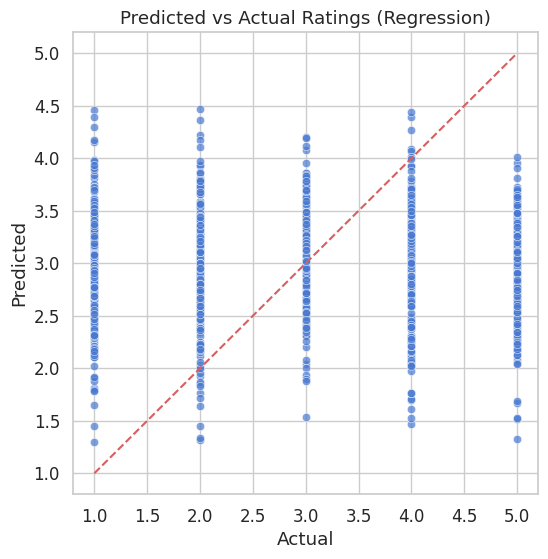

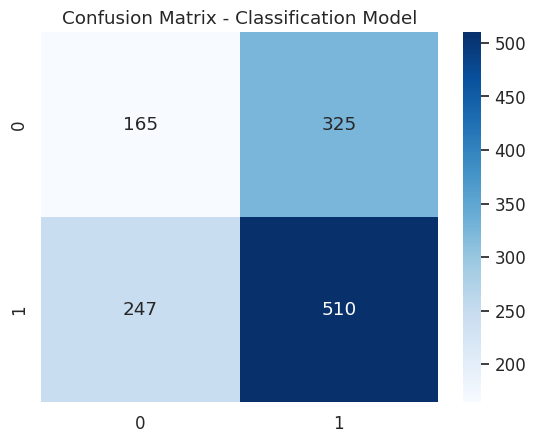

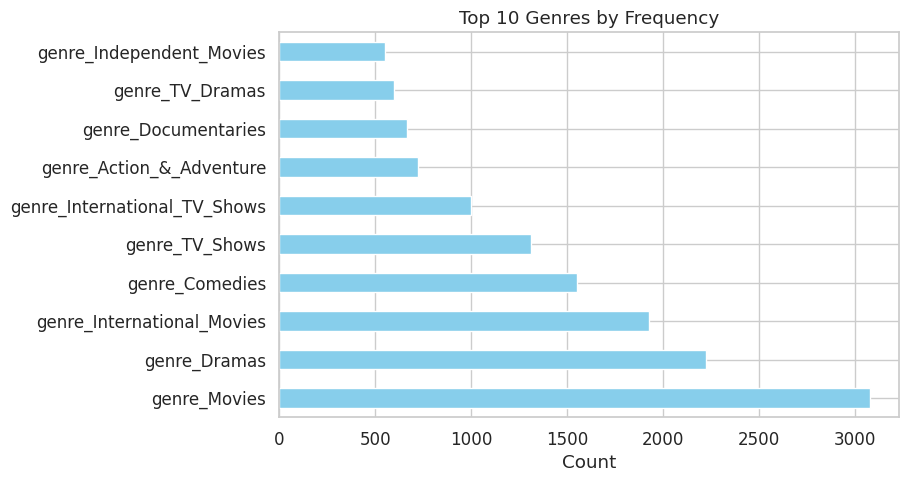

In [13]:
# Regression Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg, alpha=0.7)
plt.plot([1,5],[1,5],'--r')
plt.title("Predicted vs Actual Ratings (Regression)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Classification Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Classification Model")
plt.show()

# Genre Distribution
genre_cols = [col for col in df_clean.columns if col.startswith("genre_")]
genre_sums = df_clean[genre_cols].sum().sort_values(ascending=False).head(10)
genre_sums.plot(kind='barh', figsize=(8,5), color='skyblue')
plt.title("Top 10 Genres by Frequency")
plt.xlabel("Count")
plt.show()


## Feature Importance

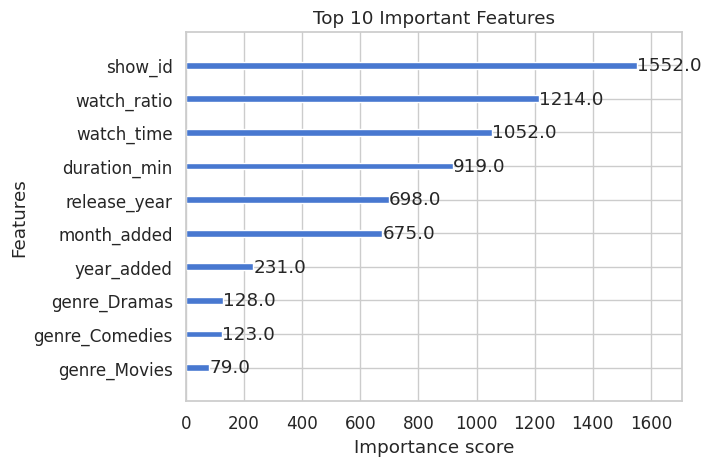

In [14]:
# Feature Importance
xgb.plot_importance(classifier, max_num_features=10, importance_type='weight', title="Top 10 Important Features")
plt.show()


## Reflection

Through this project, I learned how to:
- Build a **full ML pipeline** from raw data to evaluation  
- Engineer meaningful features (like `watch_ratio`)  
- Train and interpret **XGBoost** models for both regression and classification  
- Visualize model performance and feature importance  
- Prepare code for **AWS SageMaker deployment**

---

## Next Steps
- Integrate AWS S3 + SageMaker for automatic training & deployment  
- Add a real collaborative filtering or hybrid recommender  
- Build a simple **Streamlit dashboard** for movie suggestions  
- Automate retraining pipeline using AWS Lambda & Step Functions
